In [63]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set(style="darkgrid")
#import bayespy 

import pymc3 as pm
import arviz as az
import theano.tensor as tt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import ks_2samp

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#%load_ext watermark
#%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz
print(f"Running on PyMC3 v{pm.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running on PyMC3 v3.11.4


In [64]:
data_netw = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_network.csv').drop(columns= ['TOTAL_CONV'])
data_dig = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_digital.csv')

# data_netw = pd.read_csv('../data/tv_network.csv').drop(columns= ['TOTAL_CONV'])
# data_dig = pd.read_csv('../data/tv_digital.csv')

# combining 2 dfs
data = pd.concat([data_netw, data_dig], axis= 1)

# Filter the rows where sum of the values = 0
# data = data[data.iloc[:,:-1].sum(axis=1)!=0]

In [98]:
data.head()

,TV_ANE,TV_AMC,TV_ANIMALPLANET,TV_BBCAMERICA,TV_BET,TV_BETHER,TV_BRAVO,TV_COMEDYCENTRAL,TV_COUNTRYMUSICTELEVISION,TV_FOODNETWORK,...,TV_SMITHSONIANNETWORK,TV_SYFY,TV_TRUTV,TV_TVONE,TV_USANETWORK,TV_VH1,TV_WETV,DIGITAL_HX,DIGITAL_TREMOR,TOTAL_CONV
1,0.0,0.00,2.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0
3,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.0,2.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.12,5.3,0.0,0.0,0.0,1.4,0.98,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


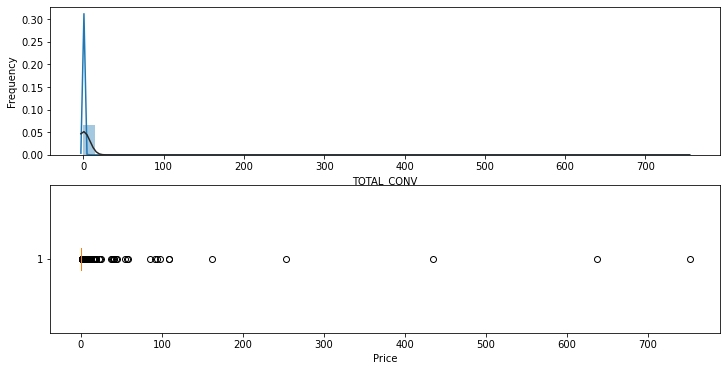

In [66]:
target_distribution(data.TOTAL_CONV)

In [67]:
# data = data[data.TOTAL_CONV != 0]
data = data[(data.TOTAL_CONV<10)] # & (data.TOTAL_CONV!=0)

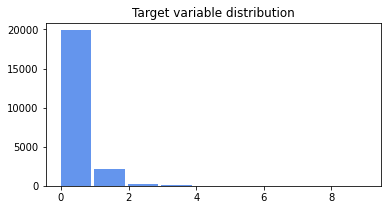

In [75]:
# target variable distribution
fig = plt.figure(figsize=(6,3))
plt.hist(data.TOTAL_CONV,
         color = 'cornflowerblue',
         width=0.9, bins =100)
plt.title(label= 'Target variable distribution')
plt.show()

In [76]:
x = data[[col for col in data.columns if col != 'TOTAL_CONV']].values
y = data.TOTAL_CONV.values

In [77]:
print(f"Mean of target distribution: {round(y.mean(), 2)}")
print(f"Variance of target distribution: {round(y.std(), 2)}")

Mean of target distribution: 0.13
Variance of target distribution: 0.45


### NegativeBinomial as Likelihood
    Negative binomial regression is used to model count data for which the variance is higher than the mean (calls overdispersion). The negative binomial distribution can be thought of as a Poisson distribution whose rate parameter is gamma distributed, so that rate parameter can be adjusted to account for the increased variance.

In [127]:
with pm.Model() as model_negative_binomial:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=5)
        # Slope
        beta = pm.HalfNormal('beta', sd = 5, shape = len(data.columns[:-1]))
        # Error term
        eps = pm.Gamma('eps', alpha = 1, beta = 0.5)
        # Expected value of outcome (ML Regression with vectors)
        mu = pm.math.invlogit(alpha + pm.math.dot(x, beta))
        # Likelihood
        conv = pm.NegativeBinomial('conv', 
                                   mu = mu, 
                                   alpha = eps,  
                                   observed = y)
        pm.Potential('constrain', tt.switch(conv > y.max(), -np.inf, 0.))
        # trace_negative_binomial = pm.sample(chains = 4, target_accept = 0.95)

In [27]:
#pm.model_to_graphviz(model_negative_binomial)

In [128]:
with model_negative_binomial:
    prior_pred = pm.sample_prior_predictive()

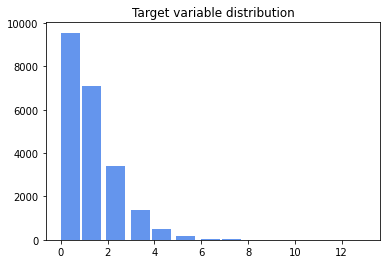

In [130]:
plt.hist(prior_pred['conv'][40],
         color = 'cornflowerblue', 
         width=0.8, bins =100)

plt.title(label= 'Target variable distribution')
plt.show()

In [138]:
with pm.Model() as model_zip:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=3)

        # Slope
        beta = pm.HalfNormal('beta', sd= 5, shape = len(data.columns[:-1]))

        psi = pm.Beta('psi', 1, 1)
        
        # Expected value of outcome (ML Regression with vectors)
        mu = pm.math.invlogit(alpha + pm.math.dot(x, beta))

        # Likelihood
        conv = pm.ZeroInflatedPoisson('conv', 
                                      theta= mu, 
                                      psi= psi,  
                                      observed=y)
        pm.Potential('constrain', tt.switch(conv > y.max(), -np.inf, 0.))
        # trace_zip = pm.sample(chains = 4, target_accept = 0.95)

In [145]:
with model_zip:
    prior_pred = pm.sample_prior_predictive()

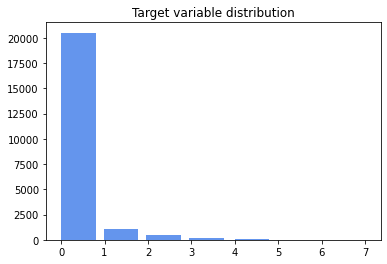

In [146]:
plt.hist(prior_pred['conv'][40],
         color = 'cornflowerblue', 
         width=0.8, bins =100)

plt.title(label= 'Target variable distribution')
plt.show()

### ZeroInflatedNegativeBinomial for Likelihood Function

In [141]:
with pm.Model() as model_zinb:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=10)
        # Slope
        beta = pm.HalfNormal('beta', sd = 10, shape = len(data.columns[:-1]))
        eps = pm.Gamma('eps', alpha = 1, beta = 0.5)
        psi = pm.Beta('psi', 1, 1)
        # Expected value of outcome (ML Regression with vectors)
        mu = pm.math.invlogit(alpha + pm.math.dot(x, beta))
        
        conv = pm.ZeroInflatedNegativeBinomial('conv', 
                                              mu = mu,
                                              psi = psi,
                                              alpha = eps,
                                              observed = y)
        
        pm.Potential('constrain', tt.switch(conv > y.max(), -np.inf, 0.))
        # trace_zinb = pm.sample(chains = 4, target_accept = 0.95)

In [147]:
with model_zinb:
    prior_pred = pm.sample_prior_predictive()

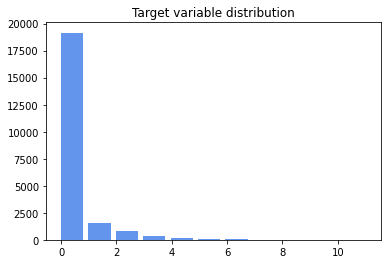

In [149]:
plt.hist(prior_pred['conv'][0],
         color = 'cornflowerblue', 
         width=0.8, bins =100)

plt.title(label= 'Target variable distribution')
plt.show()

### Using Constrain on ZeroInflatedNegativeBinomial Likelihood

### GLM Negative Binomial

In [150]:
# specifying priors and formula
formula = 'TOTAL_CONV ~ ' + ' + '.join(['%s' % variable for variable in data.columns[:-1]])

In [154]:
d_coef = {}
for val in data.columns[:-1]:
    d_coef[val] = d_coef.get(val, pm.HalfNormal.dist())

d_intercept = {'Intercept': pm.Normal.dist()}

# combining priors
d_priors = {**d_intercept,**d_coef}

In [157]:
# Context for the model
with pm.Model() as model_glm_nb:
    family = pm.glm.families.NegativeBinomial()
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula,
                        data = data, 
                        priors = d_priors, 
                        family= family)
    # pm.Potential('constrain', tt.switch(conv > y.max(), -np.inf, 0.))
    # trace_glm_nb = pm.sample(chains=4,  target_accept = 0.95)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
